# Análisis de Transacciones para BusMx (2021)
## Objetivo
Proporcionar métricas clave para optimizar ventas y seguridad en transacciones.

1. Calcula la razón de compras completadas entre los intentos totales de compra
2. Calcula el nivel de fraude *Entiéndase nivel de fraude como la razón de contracargos entre las compras totales.
3. ¿Cuáles fueron los días con mayor venta?
4. ¿Cuáles fueron los días con más intentos de compra?
5. ¿Cuáles son los orígenes más relevantes?
6. Calcula la dispersión de score de riesgo

In [3]:
import pandas as pd
import datetime
from connector import engine
today = datetime.date.today()
#Nombre de tabla para generar reporta con la fecha en la que se solicite
table_name = f"financial_analyst_{today.strftime('%Y_%m_%d')}"

¡Conexión exitosa!
Base de datos operativa


In [4]:
##Se carga a través de un archivo en excel con la base de datos a utilizar
df = pd.read_excel("Case study_ Financial analyst_.xlsx",sheet_name="Base de datos")
df.head()

,Id,payment_status,device,created_at,month,amount,antifraud_score,antifraud_action,payment_type,card_type,card_brand,card_bank_name,transporter,route,error_message
0,5339399,charged,web-mobile,2021-03-01T06:00:12.87301Z,3,144.0,23.0,accept,card,debit,visa,BANCOMER,BusMx,Uruapan-Zamora,NaN
1,5339400,failed,web-mobile,2021-03-01T06:00:20.229956Z,3,666.0,27.0,accept,card,unknown,visa,NaN,BusMx,Lagos De Moreno-Monterrey,[3012] Bank authorization is required for this...
2,5339401,failed,web-mobile,2021-03-01T06:01:00.16561Z,3,540.0,32.0,accept,card,debit,mastercard,BMONEX,BusMx,Toluca-Chiapas,[3005] Fraud risk detected by anti-fraud system
3,5339402,charged,web,2021-03-01T06:01:25.087104Z,3,442.4,32.0,accept,card,debit,visa,BANCOMER,BusMx,Ciudad de MÃ©xico-Chiapas,NaN
4,5339403,charged,web,2021-03-01T06:01:26.092279Z,3,216.0,20.0,accept,card,debit,visa,BANCOMER,BusMx,Veracruz-Morelia,NaN


In [5]:
#Se visualizan estadísticas relevantes del dataset
print(df["amount"].describe(),df["antifraud_score"].describe())

count    333605.000000
mean        763.304005
std         766.808279
min          10.000000
25%         329.000000
50%         558.000000
75%         880.000000
max       14027.300000
Name: amount, dtype: float64 count    326378.000000
mean         40.406961
std          16.283000
min          10.000000
25%          29.000000
50%          36.000000
75%          47.000000
max         100.000000
Name: antifraud_score, dtype: float64


In [6]:
#Al ver que la fila de fechas de compra es de tipo object y en formato UTC, se transforma a formato datetime con el formato ISO8601 para
#detectar variaciones en el formato de las fechas. Se comprueba el nuevo formato de fechas.
df['created_at'] = pd.to_datetime(df['created_at'], format='ISO8601', utc=True)
df["created_at"].info()
#Una vez convertido se crea una nueva columna con los días y los meses (con su nombre) para identificar los datos
df["fecha"] = df["created_at"].dt.date

<class 'pandas.core.series.Series'>
RangeIndex: 333605 entries, 0 to 333604
Series name: created_at
Non-Null Count   Dtype              
--------------   -----              
333605 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 2.5 MB


In [7]:
#Al identificarse la columna de las rutas está mal formateada, se corrige para una correcta visualización.
def fix_encoding(text):
    try:
        return text.encode("latin-1").decode("utf-8")
    except:
        return text
    
## Aplicar corrección a la columna
df["route"] = df["route"].apply(fix_encoding)

In [8]:
#Se separa el origin de la ruta, sabiendo que route está en formato origen - destino
df["origin"] = df["route"].str.split("-").str[0]
#Se comprueba la nueva columna
df.head(3)

,Id,payment_status,device,created_at,month,amount,antifraud_score,antifraud_action,payment_type,card_type,card_brand,card_bank_name,transporter,route,error_message,fecha,origin
0,5339399,charged,web-mobile,2021-03-01 06:00:12.873010+00:00,3,144.0,23.0,accept,card,debit,visa,BANCOMER,BusMx,Uruapan-Zamora,NaN,2021-03-01,Uruapan
1,5339400,failed,web-mobile,2021-03-01 06:00:20.229956+00:00,3,666.0,27.0,accept,card,unknown,visa,NaN,BusMx,Lagos De Moreno-Monterrey,[3012] Bank authorization is required for this...,2021-03-01,Lagos De Moreno
2,5339401,failed,web-mobile,2021-03-01 06:01:00.165610+00:00,3,540.0,32.0,accept,card,debit,mastercard,BMONEX,BusMx,Toluca-Chiapas,[3005] Fraud risk detected by anti-fraud system,2021-03-01,Toluca


In [9]:
#Se crea el nuevo dataframe con los datos a utilizar
df_cleaned = df[["Id","payment_status","device","fecha","amount","antifraud_score","antifraud_action","payment_type","card_type","card_brand","card_bank_name","origin","error_message"]]
print(df_cleaned.info())
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333605 entries, 0 to 333604
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                333605 non-null  int64  
 1   payment_status    333605 non-null  object 
 2   device            333605 non-null  object 
 3   fecha             333605 non-null  object 
 4   amount            333605 non-null  float64
 5   antifraud_score   326378 non-null  float64
 6   antifraud_action  326378 non-null  object 
 7   payment_type      333605 non-null  object 
 8   card_type         304621 non-null  object 
 9   card_brand        304621 non-null  object 
 10  card_bank_name    269787 non-null  object 
 11  origin            333605 non-null  object 
 12  error_message     110124 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 33.1+ MB
None


,Id,payment_status,device,fecha,amount,antifraud_score,antifraud_action,payment_type,card_type,card_brand,card_bank_name,origin,error_message
0,5339399,charged,web-mobile,2021-03-01,144.0,23.0,accept,card,debit,visa,BANCOMER,Uruapan,NaN
1,5339400,failed,web-mobile,2021-03-01,666.0,27.0,accept,card,unknown,visa,NaN,Lagos De Moreno,[3012] Bank authorization is required for this...
2,5339401,failed,web-mobile,2021-03-01,540.0,32.0,accept,card,debit,mastercard,BMONEX,Toluca,[3005] Fraud risk detected by anti-fraud system
3,5339402,charged,web,2021-03-01,442.4,32.0,accept,card,debit,visa,BANCOMER,Ciudad de México,NaN
4,5339403,charged,web,2021-03-01,216.0,20.0,accept,card,debit,visa,BANCOMER,Veracruz,NaN


In [10]:
#Se identifica la cantidad de compras completadas
completadas = (df_cleaned["payment_status"] == 'charged').sum()
#Se hace el cálculo de los intentos totales de compra. (Éxitosos y no éxitosos)
intentos_totales = len(df_cleaned["payment_status"])
#Se obtiene la razón entre ambas
razon_completadas = completadas / intentos_totales
print(f"La razón de compras completadas entre el total de compras es del: {razon_completadas:.2%}")

La razón de compras completadas entre el total de compras es del: 63.74%


In [11]:
# Calcular el nivel de fraude (contracargos / total de compras)
contracargos = (df_cleaned['payment_status'] == 'chargeback').sum()
nivel_fraude = contracargos / completadas

print(f"El nivel de fraude es de: {nivel_fraude:.2%}")

El nivel de fraude es de: 0.07%


In [12]:
## Mostrar los días con mayor venta
# Filtrar solo transacciones exitosas
df_charged = df_cleaned[df_cleaned["payment_status"] == "charged"]

# Agrupar por mes y día, sumar el monto
ventas_por_dia = (df_charged.groupby(["fecha"])["amount"].sum().reset_index().sort_values("amount", ascending=False))
ventas_por_dia.head(10)

,fecha,amount
30,2021-03-31,4430481.88
31,2021-04-01,3744489.09
29,2021-03-30,3366514.75
25,2021-03-26,3208206.67
60,2021-04-30,3181074.37
11,2021-03-12,3055490.80
28,2021-03-29,3036939.99
26,2021-03-27,2995895.21
34,2021-04-04,2874975.57
46,2021-04-16,2758050.57


In [13]:
intentos_por_dia = df_cleaned.groupby("fecha")["Id"].count().reset_index(name = "Intentos").sort_values(by = "Intentos",ascending=False)
intentos_por_dia.head(10)

,fecha,Intentos
30,2021-03-31,10196
31,2021-04-01,9273
29,2021-03-30,7991
25,2021-03-26,7769
60,2021-04-30,7753
11,2021-03-12,7408
34,2021-04-04,7381
26,2021-03-27,7239
28,2021-03-29,7128
32,2021-04-02,6982


In [14]:
# Agrupar por origen (ciudad) y calcular métricas
origenes = (
    df_charged.groupby("origin").agg(venta_total=("amount", "sum"))
    .sort_values("venta_total", ascending=False)
    .reset_index()
)
print("Orígenes más relevantes (por venta total):\n",origenes.head(10))

Orígenes más relevantes (por venta total):
              origin  venta_total
0  Ciudad de México  34323602.85
1         Monterrey  25844791.14
2           Chiapas  19402620.21
3          Delicias  10421261.79
4           Morelia   5923576.91
5   Puerto Vallarta   4713293.72
6   San Luis Potosí   4701641.48
7    Aguascalientes   4416196.89
8          Mazatlán   4168764.47
9          Veracruz   3872040.22


In [15]:
#Tendencias sobre antifraud_score
tendencias = df_cleaned.groupby('antifraud_score').agg({
    'device': lambda x: x.mode().iloc[0],  # Dispositivo más frecuente
    'amount': 'mean',  # Promedio del monto
    'antifraud_action': lambda x: x.mode().iloc[0],  # Acción antifraude más frecuente
    'payment_type': lambda x: x.mode().iloc[0] #Tipo de pago más frecuente
}).reset_index().sort_values(by="antifraud_score",ascending=False).round(2)
tendencias.head()

,antifraud_score,device,amount,antifraud_action,payment_type
90,100.0,web,389.25,reject,card
89,99.0,android,981.96,reject,card
88,98.0,web-mobile,1222.07,reject,card
87,97.0,web,1381.01,reject,card
86,96.0,web,2138.73,reject,card


In [16]:
#Ya que se comprobó que el total de datos coincide con la cantidad de filas, se visualizan los datos estadisticos
dispersion = df_cleaned["antifraud_score"].describe().reset_index(name = "Statistics").round(2)
#Se toma en cuenta que en python describe() omite filas con valores nulos, por lo que no es necesario eliminarlas del dataframe
print("Los valores en acción antifraude son:",df_cleaned["antifraud_action"].dropna().unique())
print("Las medidas de dispersion del score antifraude son:\n",dispersion)

Los valores en acción antifraude son: ['accept' 'reject']
Las medidas de dispersion del score antifraude son:
    index  Statistics
0  count   326378.00
1   mean       40.41
2    std       16.28
3    min       10.00
4    25%       29.00
5    50%       36.00
6    75%       47.00
7    max      100.00


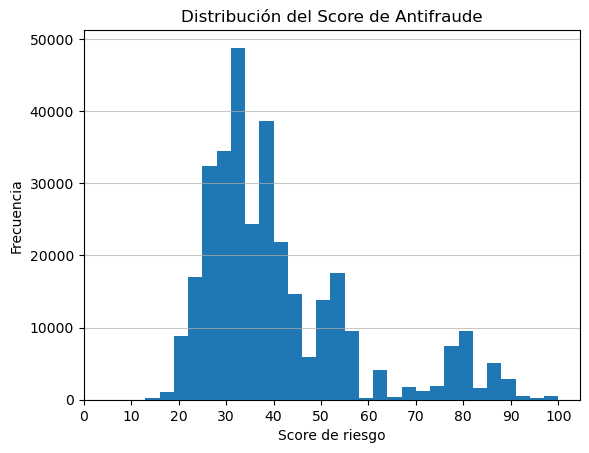

In [17]:
import matplotlib.pyplot as plt
df_cleaned["antifraud_score"].plot(kind="hist", bins=30)
plt.title("Distribución del Score de Antifraude")
# Personalizar el eje x con incrementos de 5
plt.xticks(range(0, 101, 10))  # Desde 0 hasta 100, de 5 en 5

# Añadir títulos y estilo
plt.title("Distribución del Score de Antifraude")
plt.xlabel("Score de riesgo")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="-", alpha=0.7)

plt.show()

In [18]:
#Se exporta a un archivo csv y a una base de datos sql el archivo para crear una visualización de datos.
df_cleaned.to_csv(f'{table_name}.csv',index=False)
df_cleaned.to_sql(table_name,con=engine,if_exists='replace',index=False)
#df_cleaned.to_excel(f"Financial_analyst_{today}.xlsx",engine="openpyxl",index=False)

-1

## Tecnologías Usadas
- Python (Pandas, Matplotlib)
- Power BI (para dashboards interactivos).

## Hallazgos Clave
1. **Razón de compras exitosas:** 63.74%.
2. **Nivel de fraude:** 0.07%.
3. **Día con mayor venta:** 2021-03-31 ($4,430,481). Coincidente con el inicio del período de semana santa 2024.
4. **Origen más relevante:** Ciudad de México ($34,323,602).
5. **Score de riesgo:** Se puede notar que con un score de riesgo mayor a 45 la recomendación antifraude es reject.


### Dashboard

[Enlace Power BI](https://app.powerbi.com/view?r=eyJrIjoiYTYzMDE4NWQtNWU5ZS00NTI5LTgzZWEtNzcxM2Y0NTQ1NjZkIiwidCI6ImY5NGJmNGQ5LTgwOTctNDc5NC1hZGY2LWE1NDY2Y2EyODU2MyIsImMiOjR9)

![Dashboard](https://raw.githubusercontent.com/oromero18/Portfolio/refs/heads/main/Bus_Analytics/dashboard.png)